# Introduction to Data Challenge #1: Confounded Cuisiner

As a member of the data team of an online publishing company, I have been assigned to a group interested in building a feature for a food publication that enables users to query recipes by cuisine. The first challenge, however, is that all the recipes are unlabeled, and due to the sheer volume, it is infeasible to label them by hand.

Using Natural Language Processing (NLP) and unsupervised methods, such as KMeans, Prinipal Component Analysis (PCA), and Latent Dirochlet Allocation (LDA), I have been tasked with grouping recipes by cuisine style. The food publication and the manager have clarified that in addition to grouping recipes by cuisine style, they are also interested in knowing:

* Whether it is possible to design this to be robust enough to understand similarities/subsitutions of ingredients
* What are the driving ingredients that define each cuisine style?
* How to write a guideline for an outsourced team to hand label the remaining corpus?


The following code attempts multiple models to group similar recipes by cuisine style and is grouped into the following sections:

* [EDA](#EDA)<a href='#EDA'>
    
* [Text Cleaning](#TC)<a href='#TC'>
    
* [KMeans with Bag of words](#cv)<a href='#cv'>
    
* [KMeans with Tf-idf](#tv)<a href='#tv'>
    
* [Latent Dirochlet Allocation](#LDA)<a href='#LDA'>
    
* [Conclusion](#Conclusion)<a href='#Conclusion'>

# Libraries and Data

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('notebook')
import pylab as pl

import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation as LDA, PCA

In [27]:
df = pd.read_json('unlabelled_recipies.json')

# EDA
<a id='EDA'></a>

In [28]:
df.head()

,ingredients
0,"[pepper, bacon, russet potatoes, sugar, onions..."
1,"['rib', 'carrots', 'leeks', 'unsalted butter',..."
10,"[orzo, garlic, heavy cream, white wine, spinac..."
100,"['garlic', 'ginger', 'fish sauce', 'chayotes',..."
1000,"[onions, avocado, salt, coconut cream, cumin s..."


In [29]:
df.isna().sum()

ingredients    0
dtype: int64

In [30]:
df.dtypes

ingredients    object
dtype: object

In [31]:
df.shape

(39774, 1)

In [32]:
df['ingredients'] = df['ingredients'].astype(str)

In [33]:
df = df.drop_duplicates() #There are 20 duplicates that need to be dropped.

In [34]:
df = df.reset_index()
df = df.drop(columns=['index'])

In [35]:
df.describe()

,ingredients
count,39754
unique,39754
top,"['sugar', 'onions', 'apple cider vinegar', 'sa..."
freq,1


In [36]:
df.head(2)

,ingredients
0,"['pepper', 'bacon', 'russet potatoes', 'sugar'..."
1,"['rib', 'carrots', 'leeks', 'unsalted butter',..."


In [37]:
df.ingredients[0]

"['pepper', 'bacon', 'russet potatoes', 'sugar', 'onions', 'gochugaru', 'olive oil', 'shredded cheddar cheese', 'kimchi', 'scallions', 'salt']"

In [38]:
len_recipes = df.apply(lambda x: x.str.len())
df.len_recipes = len_recipes
print(f'The shortest recipe is {len_recipes.min()[0]} characters long.')
print(f'The longest recipe is {len_recipes.max()[0]} characters long.')
print(f'The average recipe is {round(len_recipes.mean()[0])} characters long.')

The shortest recipe is 8 characters long.
The longest recipe is 1176 characters long.
The average recipe is 169.0 characters long.


/Users/kristigourlay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


# Text Cleaning
<a id='TC'></a>

For each recipe, I will now lower case, use regex to extract only letters, and then lemmatize to cut words down to the base word. Lemmatizing is important because for example onion and onions are the same. Originally I decided to convert all two word items (grated cheese, crumbled feta, warm milk) into hyphenated versions of the ingredient. However, after a first pass through, I realised that the root word had the most value. For example, the fact that two recipes used feta was essential and should not be considered diferent because one recipe called for 'crumbled feta', and the other just 'feta'.

In [39]:
lemmatizer = WordNetLemmatizer()
st = df['ingredients']

def clean_text(raw_text):
    for text in raw_text:
        lower_case = raw_text.lower()
        retokenizer = RegexpTokenizer(r'[a-z]+')
        words = retokenizer.tokenize(lower_case)
#     new_words = lemmatizer.lemmatize(words)
    new_words = " ".join(words)
    return new_words

num_excerpts = df['ingredients'].size

In [40]:
clean_text_recipes = []
num_recipes = len(df['ingredients'])

for i in range(0, num_recipes):

    clean_text_recipes.append( clean_text( st[i] ))

df['ingredients'] = clean_text_recipes

In [41]:
ingredients = df['ingredients']

In [42]:
def lemm_words(col_to_lemm):
    final_sentences = []
    for line in col_to_lemm:
        line = line.split()
        new_sentence = []
        for word in line:
            new_word = lemmatizer.lemmatize(word)
            new_sentence.append(new_word)
        final_sentences.append(new_sentence)
    
    return final_sentences

In [43]:
df['ingredients'] = lemm_words(ingredients)

In [44]:
df.head()

,ingredients
0,"[pepper, bacon, russet, potato, sugar, onion, ..."
1,"[rib, carrot, leek, unsalted, butter, finely, ..."
2,"[orzo, garlic, heavy, cream, white, wine, spin..."
3,"[garlic, ginger, fish, sauce, chayotes, cookin..."
4,"[onion, avocado, salt, coconut, cream, cumin, ..."


# KMeans Clustering with Bag of Words
<a id='cv'></a>

Using countvectorizer and looking at word counts, I decided to add certain ingredients, such as salt and pepper, to the stopwords, because they routinely appeared in recipes, and did not add much insight into the cuisine style. In addition, adjectives like red, black, chopped, and warm were descriptions of the ingredients, and again did not provide much valuable insight into the cuisine style of the recipe. This is where I decided to implement stopwords instead of hyphenating multi-word ingredients (ie. 'Crumbled Feta').

In [45]:
stopwords = ['salt', 'pepper', 'oil', 'fresh', 'red', 'water', 'black', 'chopped', 'white', 'warm', 'powder', 'frozen', 'minced', 'crushed']

cvec = CountVectorizer(stop_words=stopwords,
                        lowercase=True,
                        strip_accents='unicode')

df_cv = cvec.fit_transform(df.ingredients.apply(lambda x: np.str_(x)))

In [46]:
cvec_df = pd.DataFrame(df_cv.todense(), columns=cvec.get_feature_names())
cvec_df.head(2)

,abalone,abbamele,absinthe,abura,acai,accent,accompaniment,achiote,acid,acinus,...,yuzukosho,za,zatarain,zatarains,zero,zest,zesty,zinfandel,ziti,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
word_count = cvec_df.sum(axis=0)
word_count.sort_values(ascending=False).head(20)

onion        19242
garlic       18941
ground       18271
sauce        13188
sugar        12497
olive        12281
cheese       11773
chicken      11557
tomato       11205
green         9089
egg           9039
flour         8848
butter        8642
clove         8177
leaf          7549
juice         7145
cream         6092
rice          6073
cilantro      5950
vegetable     5928
dtype: int64

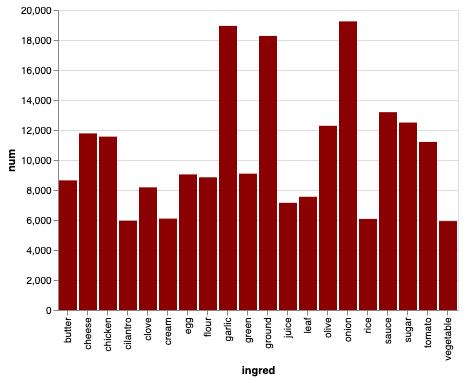

In [23]:
wc = pd.DataFrame(word_count)
wc = wc.reset_index()
wc = wc.rename(columns={'index': 'ingred', 0: 'num'})
wc = wc.sort_values(by='num', ascending=False).head(20)

Chart = alt.Chart(wc).mark_bar(color='darkred').encode(
    x='ingred',
    y='num'
)

Chart

In [24]:
cvec_df.head()

,abalone,abbamele,absinthe,abura,acai,accent,accompaniment,achiote,acid,acinus,...,yuzukosho,za,zatarain,zatarains,zero,zest,zesty,zinfandel,ziti,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
number_of_clusters = 10
km = KMeans(n_clusters = number_of_clusters)

km.fit(cvec_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [26]:
df['predicted'] = km.labels_
cvec_df['predicted'] = km.labels_

In [27]:
def plot_pca(n, df):
    pca = PCA(n_components=n)
    projected = pca.fit_transform(df)
    print(df.shape)
    print(projected.shape)


    plt.scatter(projected[:, 0], projected[:, 1],
                c=df.predicted, edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('Spectral', 10))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.colorbar();

(39754, 2758)
(39754, 2)


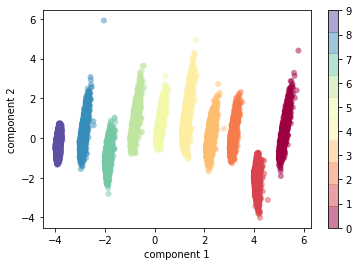

In [28]:
plot_pca(2, cvec_df)

Now I will look at how many components are needed to describe the data, by looking at the cumulative explained variance ratio (plotted below). This curve quantifies how much of the 2731-dimensional variance is contained within the first N components. As we can see below, that nearly 200 of the 2761 components describe 90% of the variance, while you need about 750 to describe closer to 100% of the variance.

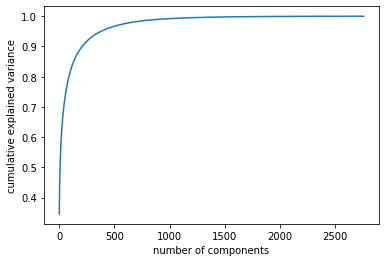

In [29]:
def plot_variance(df):
    pca = PCA().fit(df)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    
plot_variance(cvec_df)

In [30]:
def words_by_cluster(df, n):
    
    pred = df[df.predicted == n]
    
    return pred.sum(axis=0).sort_values(ascending=False).head(20)

In [31]:
words_by_cluster(cvec_df, 0)[1:] #slicing the list at 1 because predicted appeared in each category

onion       1748
cream       1528
tortilla    1462
shredded    1383
ground      1248
green       1151
tomato      1139
corn        1075
sour        1075
cheddar     1064
chicken     1028
bean         944
garlic       885
cilantro     830
sauce        824
salsa        789
flour        751
cumin        688
olive        639
dtype: int64

With a bag of words model, and looking at most frequent words, some cuisine styles were easy to assess. For example, topic 9 was baking recipes, and topic 1 was south-east Asian. However, it seemed that 3 categories could be Italian (oregano, parmesan, mozarella), and 3 more had Mexican influence (cilantro, garlic, peppers, tortilla, etc.) This could be because the proportion of Italian and Mexican recipes is higher that those of other styles. As a result these more basic models are clustering within these larger cuisines and othering other cuisines into one larger cluster (for example all Asian food). There are some clear distinctions appearing, but not not precise enough yet for the task at hand.

# KMeans Clusting with Tf-idf
<a id='tv'></a>

Since many words are common to many recipes but still provide valuable insight (eggs, flour, sauce, etc.), I will also use Tf-idf to find the inverse frequency of terms.

In [32]:
tvec = TfidfVectorizer(stop_words=stopwords,
                        encoding='utf-8')

df_tv = tvec.fit_transform(df.ingredients.apply(lambda x: np.str_(x)))

In [33]:
tvec_df = pd.DataFrame(df_tv.todense(), columns=tvec.get_feature_names())
tvec_df.head()

,abalone,abbamele,absinthe,abura,acai,accent,accompaniment,achiote,acid,acinus,...,yuzukosho,za,zatarain,zatarains,zero,zest,zesty,zinfandel,ziti,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
word_count2 = tvec_df.sum(axis=0)
word_count2.sort_values(ascending=False).head(20)

ground       2157.782338
onion        2030.145834
garlic       1993.847368
sauce        1741.605965
sugar        1721.934123
olive        1677.858898
cheese       1665.516854
chicken      1582.366625
tomato       1571.270475
flour        1406.725537
egg          1396.822392
butter       1349.860914
green        1341.179610
clove        1209.075163
juice        1163.833148
leaf         1147.606615
milk         1054.453580
lemon        1050.407040
vegetable    1028.953727
rice         1025.190362
dtype: float64

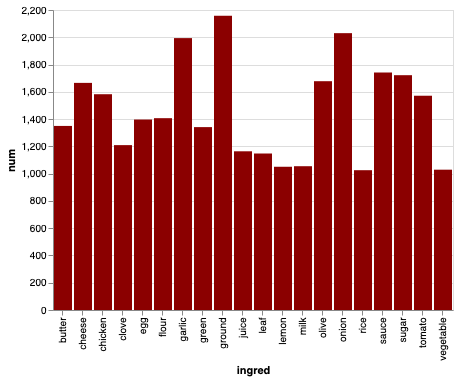

In [35]:
wc2 = pd.DataFrame(word_count2)
wc2 = wc2.reset_index()
wc2 = wc2.rename(columns={'index': 'ingred', 0: 'num'})
wc2 = wc2.sort_values(by='num', ascending=False).head(20)

Chart = alt.Chart(wc2).mark_bar(color='darkred').encode(
    x='ingred',
    y='num'
)

Chart

In [36]:
number_of_clusters = 10
km = KMeans(n_clusters = number_of_clusters)

km.fit(tvec_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [37]:
tvec_df['predicted'] = km.labels_

(39754, 2758)
(39754, 2)


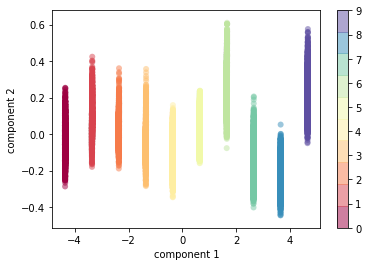

In [38]:
plot_pca(2, tvec_df)

In [ ]:
plot_variance(tvec_df)

The cumulative explained variance ratio (plotted above) quantifies how much of the 2761-dimensional variance is contained within the first N components. As we can see, a very low number of components (possibly below 25) describes 90% of the variance. This signals that the clusters made by KMeans with Tf-idf vectors probably provides much more insight.

In [39]:
def freq_by_cluster(df, n):
    
    pred = df[df.predicted == n]
    
    return pred.sum(axis=0).sort_values(ascending=False).head(20)

In [40]:
freq_by_cluster(tvec_df, 0) # Asian, maybe Thai?

lime        663.629249
cilantro    421.413018
juice       381.094514
onion       240.382034
chilies     218.302328
jalapeno    215.465858
garlic      213.009237
fish        191.393443
chile       190.644827
sauce       183.584003
avocado     179.248942
tomato      161.552565
ground      146.488210
leaf        144.830985
chicken     142.180581
sugar       136.596603
green       134.328397
coconut     128.891927
purple      128.258012
clove       126.790918
dtype: float64

In [41]:
freq_by_cluster(tvec_df, 1)[1:] # Italian

cheese        704.292304
parmesan      533.696174
grated        400.525059
mozzarella    259.707505
olive         215.746166
basil         199.559793
garlic        188.237100
tomato        183.924267
pasta         174.677776
ground        166.641803
italian       146.314860
egg           138.124336
parsley       136.240251
dried         136.066101
butter        132.713458
ricotta       131.959002
onion         126.475723
sauce         125.762790
bread         113.766295
dtype: float64

In [42]:
freq_by_cluster(tvec_df, 2) # Asian

predicted    9812.000000
sauce         894.279276
soy           804.375177
sesame        630.090744
rice          408.656270
ginger        406.210908
sugar         363.584663
garlic        347.618421
vinegar       301.048336
onion         288.702225
chicken       284.465399
green         261.953729
starch        257.584204
scallion      226.819189
corn          208.741373
vegetable     207.997548
peanut        192.183209
pork          189.788786
seed          185.212904
chili         172.940933
dtype: float64

In [43]:
freq_by_cluster(tvec_df, 3) #Italian

predicted    7251.000000
virgin        534.540083
extra         523.445431
olive         388.639773
garlic        168.911068
clove         153.206471
leaf          150.788194
lemon         142.194757
tomato        141.770004
ground        134.489859
parsley       121.436205
wine          110.629744
cheese        109.164151
vinegar       103.683747
juice         101.882546
basil         100.551352
onion          97.066540
kosher         83.699716
flat           81.922092
sea            70.278672
dtype: float64

In [44]:
freq_by_cluster(tvec_df, 4) #Mexican

predicted    21724.000000
tomato         529.360802
onion          490.902231
garlic         465.001489
dried          462.447674
olive          455.692192
chicken        425.525980
bell           338.485943
leaf           335.375694
ground         334.314444
parsley        313.903111
green          309.616364
clove          308.497499
broth          307.865799
thyme          300.970265
oregano        274.322528
celery         255.999643
wine           249.552681
bay            237.271157
diced          218.602781
dtype: float64

In [45]:
freq_by_cluster(tvec_df, 5)

predicted    45235.000000
lemon          358.606734
butter         343.856347
sugar          339.502504
onion          301.620877
ground         280.103487
juice          256.697591
garlic         250.522181
milk           247.292381
egg            242.260799
olive          240.555090
potato         225.624480
vinegar        210.839824
cream          205.163490
cheese         204.328593
chicken        183.900590
vegetable      183.241803
sauce          180.061654
green          177.758946
bread          162.185944
dtype: float64

In [46]:
freq_by_cluster(tvec_df, 6) #Baking

predicted     17784.000000
flour           591.150935
purpose         546.282759
all             546.162805
baking          420.464406
egg             319.473372
butter          291.567436
sugar           261.227790
milk            219.524893
large           191.232477
buttermilk      187.210922
unsalted        171.255924
soda            164.424576
yeast           153.042922
vegetable       129.800204
ground          119.123605
dry             105.701659
active           99.833636
cornmeal         90.873151
shortening       82.593132
dtype: float64

In [47]:
freq_by_cluster(tvec_df, 7) #Mexican

predicted    20153.000000
cheese         414.933299
tortilla       397.523179
shredded       336.206552
cheddar        307.844120
cream          290.206180
salsa          266.940862
sour           265.029234
corn           236.769319
onion          211.646740
bean           211.335487
jack           204.686975
chicken        193.598193
green          186.872178
ground         181.237871
tomato         180.452045
taco           157.792009
cilantro       157.491612
cumin          152.348231
chili          144.165285
dtype: float64

In [48]:
freq_by_cluster(tvec_df, 8) #Indian

predicted    24264.000000
ground         554.156894
cumin          396.115305
seed           369.985541
coriander      331.258426
ginger         270.919256
masala         243.456152
garam          222.174728
onion          217.121630
turmeric       216.921838
chili          207.433587
garlic         205.758477
tomato         196.861083
cilantro       180.926543
cinnamon       177.492447
leaf           167.446433
clove          163.307997
tumeric        156.514343
curry          152.437346
green          134.497556
dtype: float64

In [49]:
freq_by_cluster(tvec_df, 9) #Baking

predicted     23697.000000
sugar           450.948501
vanilla         449.454061
extract         379.997174
egg             353.884258
butter          246.220439
milk            235.344772
cream           227.991055
large           219.608537
flour           191.085535
yolk            171.155437
chocolate       149.112763
baking          143.877706
unsalted        138.120921
purpose         135.438341
all             135.375176
cinnamon        124.012790
granulated      114.867362
brown           112.729369
almond          112.726646
dtype: float64

I attempted to shrink and increase the number of clusters. 10 seems to be the optimal number. Anyless than 10, and the model loses Indian food, anymore, and more indistinuishable pastry type categories emerge. However, using Tf-idf with KMeans clusters did a little better than the bag of words model. We were able identify two more categories: Indian and another Asian inspired cluster, possibly Thai food.

# LDA
<a id='LDA'></a>

Moving on from KMeans clustering, I will now attempt to use a more advanced model for the task at hand. Using LDA, I will see if there are clearer distinctions between targets/clusters by analyzing distributions of 'topics' among recipes and distributions of ingredients among topics.

In [ ]:
# GridSearch LDA

search_params = {'n_components': [5, 12, 10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

lda = LDA()

model = GridSearchCV(lda, param_grid=search_params)

model.fit(df_cv)

/Users/kristigourlay/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [47]:
lda = LDA(n_components=10, random_state=42)
lda.fit_transform(df_cv)
pyLDAvis.sklearn.prepare(lda, df_cv, cvec)

/Users/kristigourlay/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.392850  0.045511       1        1  14.597295
3      0.058540  0.169792       2        1  14.229735
7      0.026035 -0.006368       3        1  10.725374
5      0.019673  0.012084       4        1  10.574498
1     -0.034589 -0.202516       5        1  10.348313
6      0.097837  0.000406       6        1   9.520798
4     -0.055710 -0.066913       7        1   8.550587
0      0.070350 -0.223780       8        1   8.365668
8      0.165468  0.004499       9        1   8.309044
2      0.045246  0.267286      10        1   4.778688, topic_info=     Category          Freq        Term         Total  loglift  logprob
472   Default  11421.000000      cheese  11421.000000  30.0000  30.0000
1401  Default   4842.000000        lime   4842.000000  29.0000  29.0000
2175  Default  13116.000000       sauce  13116.000000  28.0000  28.0000
1718  Default  12361.000000       olive  12361.000000  27.0000  27.0000
2426  Default  12256.000000       sugar  12256.000000  26.0000  26.0000
2332  Default   4874.000000         soy   4874.000000  25.0000  25.0000
484   Default  11722.000000     chicken  11722.000000  24.0000  24.0000
913   Default   8618.000000       flour   8618.000000  23.0000  23.0000
533   Default   5853.000000    cilantro   5853.000000  22.0000  22.0000
2311  Default   2485.000000      sodium   2485.000000  21.0000  21.0000
853   Default   2796.000000         fat   2796.000000  20.0000  20.0000
36    Default   4715.000000         all   4715.000000  19.0000  19.0000
2001  Default   4707.000000     purpose   4707.000000  18.0000  18.0000
1008  Default   5382.000000      ginger   5382.000000  17.0000  17.0000
2219  Default   3502.000000      sesame   3502.000000  16.0000  16.0000
1433  Default   2460.000000         low   2460.000000  15.0000  15.0000
2663  Default   5034.000000     vinegar   5034.000000  14.0000  14.0000
310   Default   4682.000000       broth   4682.000000  13.0000  13.0000
639   Default   5895.000000       cream   5895.000000  12.0000  12.0000
2538  Default  11224.000000      tomato  11224.000000  11.0000  11.0000
1261  Default   7073.000000       juice   7073.000000  10.0000  10.0000
685   Default   4591.000000       cumin   4591.000000   9.0000   9.0000
2207  Default   4044.000000        seed   4044.000000   8.0000   8.0000
2070  Default   6122.000000        rice   6122.000000   7.0000   7.0000
804   Default   8882.000000         egg   8882.000000   6.0000   6.0000
1792  Default   2893.000000    parmesan   2893.000000   5.0000   5.0000
837   Default   3155.000000       extra   3155.000000   4.0000   4.0000
130   Default   2877.000000      baking   2877.000000   3.0000   3.0000
2666  Default   2822.000000      virgin   2822.000000   2.0000   2.0000
2262  Default   2583.000000    shredded   2583.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
2678  Topic10     92.414773      wasabi    103.744942   2.9254  -5.8412
2053  Topic10    847.271045     reduced   1035.376251   2.8405  -3.6255
853   Topic10   2170.497045         fat   2796.862393   2.7875  -2.6848
1660  Topic10    109.215472      nectar    124.940868   2.9065  -5.6742
285   Topic10    193.867438  breadcrumb    235.044487   2.8484  -5.1004
2146  Topic10    269.160955        sake    371.042702   2.7200  -4.7722
1582  Topic10    346.177932       mirin    535.845309   2.6041  -4.5206
244   Topic10    111.173443      boiled    151.934166   2.7286  -5.6564
310   Topic10   1749.634848       broth   4682.239408   2.0566  -2.9004
2151  Topic10    201.596620      salmon    340.618778   2.5165  -5.0613
1522  Topic10    130.005338  mayonnaise    189.264697   2.6654  -5.5000
2242  Topic10    308.010201    shiitake    642.310231   2.3061  -4.6374
484   Topic10   2349.813802     chicken  11722.453799   1.4338  -2.6054
1808  Topic10    203.288609      pastry    371.872078   2.4371  -5.05

Using LDA and GridSearch I was able to find the best parameters. With this model, using 10 components was optimal. The topics seemed to be as followed:

* French (wine, thyme, bay leaves, celery, broth)
* South-east Asian (Chinese) (ginger, rice, soy, sesame)
* Japanese (miso, mushroom, panko, salmon, dashi)
* Baking (cakes and cookies)
* Indian (spices: garam masala, tumeric, curry, garlic, ghee)
* Mexican (sourcream, shredded cheese, tortilla)
* Dips, Dressings, and Sauces (spices, creams, sauces)
* Italian (pasta and cheeses)
* Cajun, Creole? (Tomato, beans, sausage, chicken, shrimp, okra)
* Thai (lemongrass, noodle, fish, peanut)
                                                           

# Conclusion
<a id='Conclusion'></a>

By following very basic guidelines, we will be able to separate recipes into 10 different categories. By focusing on spices, vegetables, and starch, this model will be robust enough to handle substitutions and similarities of ingredients.

# Guidelines for Out-Sourcing

Take into consideration the most frequent ingredients for each cuisine style. The three steps you should take are: spices, produce, starch.
1. The most important for classification are spices:
    * are they savoury or sweet? (Sweet is dessert. Savoury is main)
    * spices unique/common in certain areas of the world (garam masala in indian)?
2. Second most important are vegetables.
    * Bean sprouts, lime, lemongrass (Thai)
    * Jalepeno, pablano, chipotle (Mexican)
3. Third would be starch.
    * bread = Northern European
    * pasta, dough = Italian
    * tortilla = Mexican
    * rice = South-East Asian
    * noodle = Thai
                     

# Taking it further (If I had more than 4 hours!)

Now that we have successfully identified 10 "topics" of cuisine. I would like to use hierarchical LDA. I would look at these topics individually and try and find the common categories within them. For examples, Desserts could be seperated into Cookies, Cakes, Squares, Pies etc. Doing this would also most likely allow for more clusters/categories within the Asian category where I am sure Japanese, Chinese, Korean, etc food are being clustered together because there are less of them compared to the larger categories (Italian, Mexican, etc.), and they share similar ingredients in comparison to other geographical areas. 